## Importing libraries and loading dataset

In [68]:
import pandas as pd
import numpy as np
import optuna 
from optuna import study

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

from catboost import CatBoostRegressor
import optuna

import warnings
warnings.filterwarnings('ignore')

In [69]:
input_dir = 'C:/Users/vadim.sokolov/Desktop/В/'
timeseries_df = pd.read_excel(f'{input_dir}/test5/BurgerKing_TimeSeries_TEST.xlsx', 
                              sheet_name='TimeSeries')
calendar_df = pd.read_excel(f'{input_dir}test5/BurgerKing_TimeSeries_TEST.xlsx', 
                            sheet_name='Calendar')

In [70]:
timeseries_df.describe()

,key,y,ddd
count,10016.000000,10016.000000,10016.000000
mean,3.232528,674.183506,179.462061
std,1.351298,324.145112,105.215739
min,1.000000,1.000000,1.000000
25%,2.000000,470.000000,87.000000
50%,3.000000,639.000000,177.000000
75%,4.000000,823.000000,270.000000
max,5.000000,2268.000000,366.000000


In [71]:
items_in_data = timeseries_df.key.unique()
print(items_in_data)
print("Number of items in the dataset: " + str(len(items_in_data)))

[1 2 3 4 5]
Number of items in the dataset: 5


In [72]:
timeseries_df.key.value_counts()

4    2764
5    2106
3    1996
2    1653
1    1497
Name: key, dtype: int64

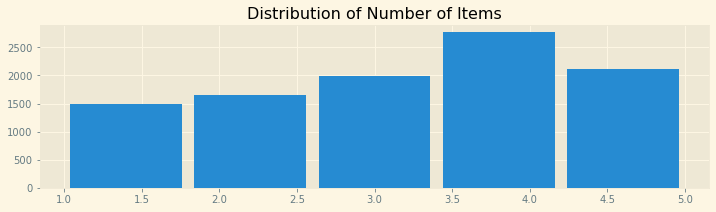

In [73]:
fig = plt.figure(figsize = (12,3))
plt.hist(timeseries_df.key, rwidth = 0.9, bins = len(timeseries_df.key.unique()))
plt.title('Distribution of Number of Items')
plt.show()

In [74]:
timeseries_df.isnull().sum()

key    0
ds     0
y      0
ddd    0
dtype: int64

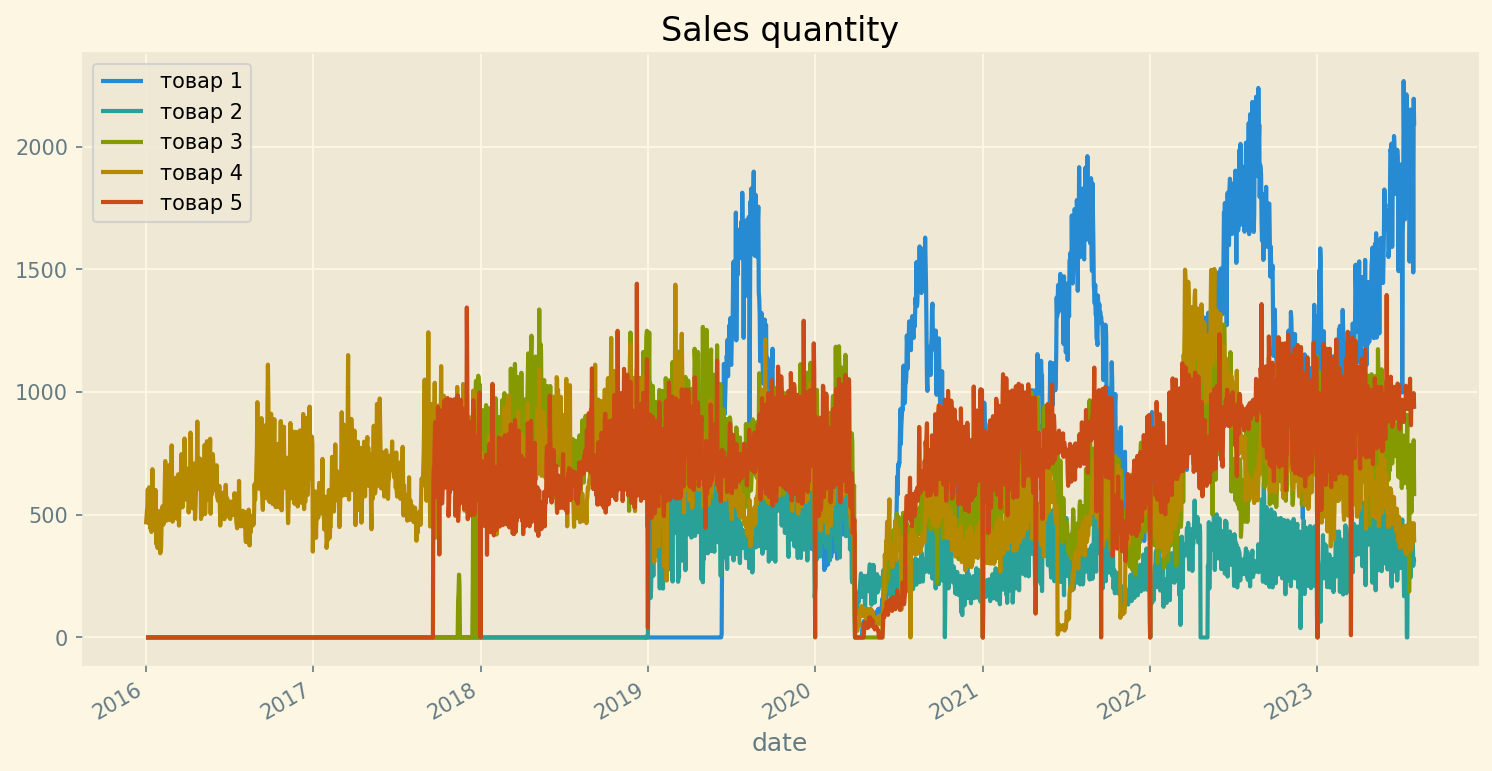

In [75]:
timeseries = timeseries_df[['ds','key','y']]
timeseries_1 = timeseries.pivot_table('y', ['ds'], 'key').fillna(0)

plt.figure(figsize=(12, 6), dpi=150)

timeseries_1.iloc[:,0].plot(label = 'товар 1')
timeseries_1.iloc[:,1].plot(label = 'товар 2')
timeseries_1.iloc[:,2].plot(label = 'товар 3')
timeseries_1.iloc[:,3].plot(label = 'товар 4')
timeseries_1.iloc[:,4].plot(label = 'товар 5')

plt.title('Sales quantity')
plt.xlabel('date')
plt.legend(loc='upper left')

In [76]:
timeseries = timeseries.set_index('ds')

### Time Series Decomposition

<Figure size 432x288 with 0 Axes>

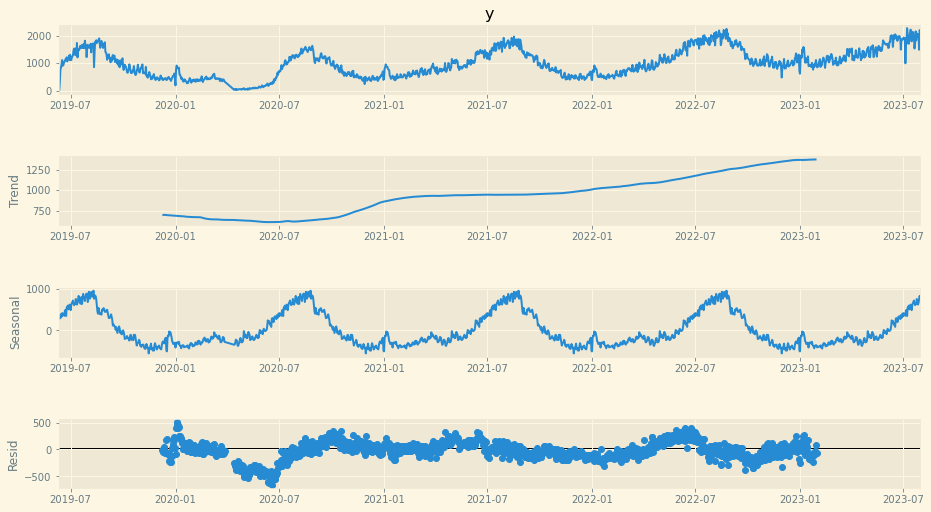

In [77]:
# Yearly trend/seasonality/residuals

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(timeseries.query('key==1')['y'], model = 'additive', period = 365) # выбрать товар - key==?

fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(15,8)

<Figure size 432x288 with 0 Axes>

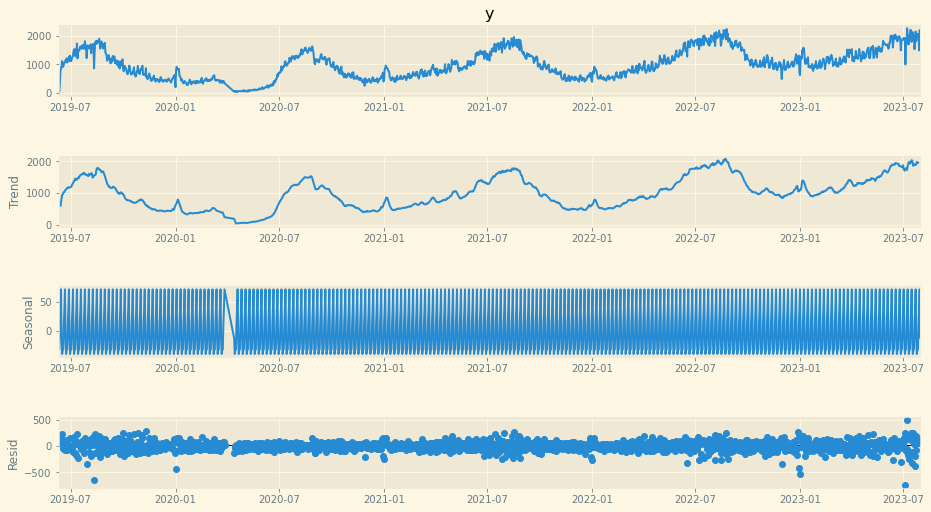

In [78]:
# Weekly trend/seasonality/residuals

decomp = seasonal_decompose(timeseries.query('key==1')['y'], model = 'additive', period = 7)

fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(15,8)

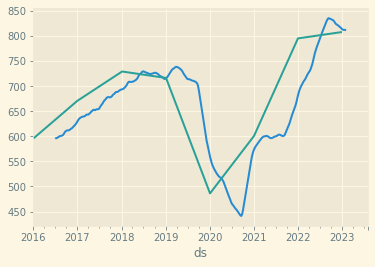

In [79]:
# тренд для всех товаров суммарно.
week_timeseries = timeseries['y'].resample('W').mean()
year_timeseries = timeseries['y'].resample('Y').mean()

components_week = sm.tsa.seasonal_decompose(week_timeseries, model = 'additive')
components_year = sm.tsa.seasonal_decompose(year_timeseries, model = 'additive')

# тренд 
components_week.trend.plot()
components_year.trend.plot()
plt.show()

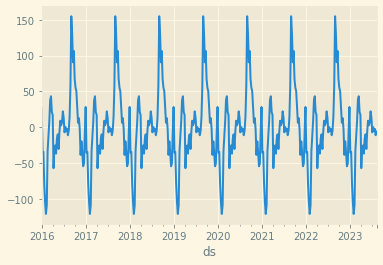

In [80]:
# сезонность 
components_week.seasonal.plot()
plt.show()

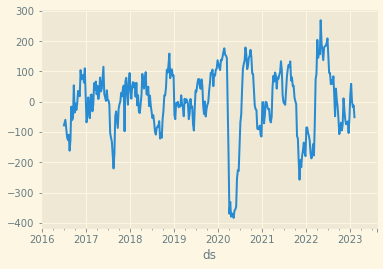

In [81]:
# сезонность 
components_week.resid.plot()
plt.show()

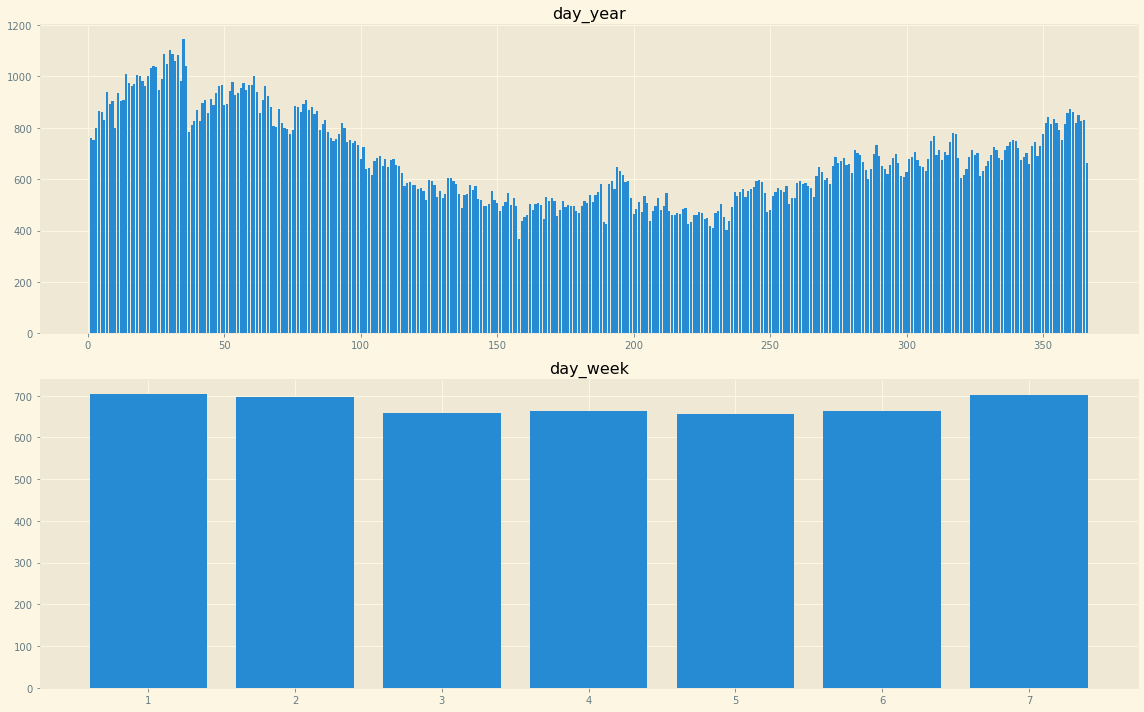

In [82]:
# сезонность внутри года, недели

timeseries = pd.merge(timeseries.reset_index(drop=True), 
              calendar_df[['day_week','day_year']], how='left', left_index=True, right_index=True)
timeseries.head()

nrows, ncols = 2,1 
fig, ax = plt.subplots(nrows, ncols, figsize=(16,10))

for i, col in enumerate(['day_year','day_week']): 
    plot_data = timeseries.groupby(col)['y'].mean()
    
    cax = plt.subplot(nrows, ncols, i+1)
    cax.bar(plot_data.index, plot_data.values)
    # Need to add automatic adding of labels of x-axis
    cax.set_title('{}'.format(col, fontsize=10))

plt.tight_layout()
plt.show()

pd.options.mode.chained_assignment = 'warn'

In [83]:
timeseries_df['y'].isnull().value_counts()

False    10016
Name: y, dtype: int64

In [84]:
# масштабирование и определение аномальных значений с помощью IsolationForest.

scaler = StandardScaler()
data_scale = pd.DataFrame(scaler.fit_transform(timeseries_df['y'].array.reshape(-1, 1)),columns=['y_sc'])

from sklearn.ensemble import IsolationForest

outliers_fraction = float(.01)
model =  IsolationForest(n_estimators=200, 
                         max_samples = 5, 
                         bootstrap = True, 
                         random_state = 47,
                         contamination=outliers_fraction)
model.fit(data_scale)

IsolationForest(bootstrap=True, contamination=0.01, max_samples=5,
                n_estimators=200, random_state=47)

In [85]:
data_scale['anomaly'] = model.predict(data_scale)
data_scale = pd.merge(data_scale, timeseries_df, left_index=True, right_index=True, how='left')
data_scale.head(5)

,y_sc,anomaly,key,ds,y,ddd
0,-2.076900,1,1,2019-06-10,1,161
1,-2.036793,1,1,2019-06-11,14,162
2,-1.055702,1,1,2019-06-12,332,163
3,0.295612,1,1,2019-06-13,770,164
4,0.511576,1,1,2019-06-14,840,165


In [86]:
# аномальные значения были найдены только у 1го товара.
data_scale.groupby(['key','anomaly'])['anomaly'].sum()

key  anomaly
1    -1          -60
      1         1437
2     1         1653
3     1         1996
4     1         2764
5     1         2106
Name: anomaly, dtype: int32

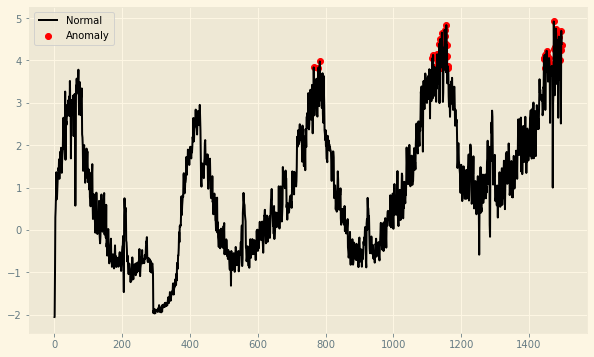

In [87]:
# визуализация товара 1 с аномальными выбросами.
fig, ax = plt.subplots(figsize=(10,6))
data_scale1 = data_scale.query('key==1')[['y_sc','anomaly']]
a = data_scale1.loc[data_scale1['anomaly'] == -1, ['y_sc']] #anomaly
ax.plot(data_scale1.index, data_scale1['y_sc'], color='black', label = 'Normal')
ax.scatter(a.index, a['y_sc'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

In [88]:
# заменяем аномальные значения на предыдущие во временном ряде.
def conditions(data_scale):
    if data_scale['anomaly'] == 1:
        return data_scale['y_sc']
    else:
        return 0

data_scale['y_no_outl'] = data_scale.apply(lambda x: conditions(x), axis=1)
data_scale['y_no_outl'] = data_scale['y_no_outl'].replace(to_replace=0, method='ffill')
data_scale.head()

,y_sc,anomaly,key,ds,y,ddd,y_no_outl
0,-2.076900,1,1,2019-06-10,1,161,-2.076900
1,-2.036793,1,1,2019-06-11,14,162,-2.036793
2,-1.055702,1,1,2019-06-12,332,163,-1.055702
3,0.295612,1,1,2019-06-13,770,164,0.295612
4,0.511576,1,1,2019-06-14,840,165,0.511576


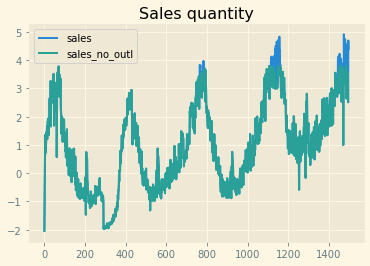

In [89]:
#  Аномальные и выколотые точки с заменёнными значениями (по min/max thresold)

data_scale.loc[data_scale['key'] == 1, 'y_sc'].plot(label = 'sales')
data_scale.loc[data_scale['key'] == 1, 'y_no_outl'].plot(label = 'sales_no_outl')

plt.title('Sales quantity')
plt.legend(loc='upper left')

In [90]:
df2 = pd.merge(data_scale, calendar_df, left_on='ds', right_on='day_id', how='outer')
df2.sort_values(by=['key','day_id'], inplace=True)
df2.head()

,y_sc,anomaly,key,ds,y,ddd,y_no_outl,day_id,week_id,month_id,year_id,day_year,day_week,day_number,week_number,month_number,quarter_number,is_holiday,is_warm,is_black_friday
0,-2.076900,1.0,1.0,2019-06-10,1.0,161.0,-2.076900,2019-06-10,201924,201906,2019,161,1,10,24,6,2,0,1,0
5,-2.036793,1.0,1.0,2019-06-11,14.0,162.0,-2.036793,2019-06-11,201924,201906,2019,162,2,11,24,6,2,0,1,0
10,-1.055702,1.0,1.0,2019-06-12,332.0,163.0,-1.055702,2019-06-12,201924,201906,2019,163,3,12,24,6,2,1,1,0
15,0.295612,1.0,1.0,2019-06-13,770.0,164.0,0.295612,2019-06-13,201924,201906,2019,164,4,13,24,6,2,0,1,0
20,0.511576,1.0,1.0,2019-06-14,840.0,165.0,0.511576,2019-06-14,201924,201906,2019,165,5,14,24,6,2,0,1,0


In [91]:
df2['key'].isnull().value_counts()

False    10016
True       522
Name: key, dtype: int64

In [92]:
# удаляе строки у которых отсутствует информация о товаре.
df2 = df2[df2['key'].notna()]
df2['key'].isnull().value_counts()

False    10016
Name: key, dtype: int64

In [93]:
df_fact = df2[['key','ds','y']]
df2.drop(['ds','y','y_sc'], axis=1, inplace=True)  # ,'y_sc'
df2.head(5)

,anomaly,key,ddd,y_no_outl,day_id,week_id,month_id,year_id,day_year,day_week,day_number,week_number,month_number,quarter_number,is_holiday,is_warm,is_black_friday
0,1.0,1.0,161.0,-2.076900,2019-06-10,201924,201906,2019,161,1,10,24,6,2,0,1,0
5,1.0,1.0,162.0,-2.036793,2019-06-11,201924,201906,2019,162,2,11,24,6,2,0,1,0
10,1.0,1.0,163.0,-1.055702,2019-06-12,201924,201906,2019,163,3,12,24,6,2,1,1,0
15,1.0,1.0,164.0,0.295612,2019-06-13,201924,201906,2019,164,4,13,24,6,2,0,1,0
20,1.0,1.0,165.0,0.511576,2019-06-14,201924,201906,2019,165,5,14,24,6,2,0,1,0


In [94]:
# Создание тестового df для построения прогноза с 31.07.2023.

test1 = calendar_df.loc[calendar_df.day_id > pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()
test2 = calendar_df.loc[calendar_df.day_id > pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()
test3 = calendar_df.loc[calendar_df.day_id > pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()
test4 = calendar_df.loc[calendar_df.day_id > pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()
test5 = calendar_df.loc[calendar_df.day_id > pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()

test1['key'] = 1
test2['key'] = 2
test3['key'] = 3
test4['key'] = 4
test5['key'] = 5

df = pd.concat([df2, test1, test2, test3, test4, test5], ignore_index=True)

In [95]:
df['sum_fact'] = df.groupby(['key','week_id'])['y_no_outl'].transform('sum').astype(np.float16)
df['proportion'] = df['y_no_outl'] / df['sum_fact']

# Trend
df['day_avg_sold'] = df.groupby(['key','day_id'])['y_no_outl'].transform('mean').astype(np.float16)
# Total Average by SKU (Item Id + Store)
df['avg_sold'] = df.groupby(['key'])['y_no_outl'].transform('mean').astype(np.float16)
# Selling Trend
df['trend'] = (df['day_avg_sold'] - df['avg_sold']).astype(np.float16)

for i in [1,2,3,4,5,6,7,14,28,56]:
    print('lag_period',i)
    df['lag_'+str(i)] = df.groupby(['key'])['y_no_outl'].shift(i)

for i in [1,2,3,4,5,6,7,14,28,56]:
    print('lag_period',i)
    df['lag_'+str(i)] = df.groupby(['key'])['proportion'].shift(i)    

for i in [1,2,3,4,5,6,7,14,28,56]:
    print('lag_period',i)
    df['lag_'+str(i)] = df.groupby(['key'])['trend'].shift(i)
    
SHIFT_WEEK = 7
for i in [1,2,3,4,5,6,7,14,28,56]:
    print('Rolling period:', i)
    df['f_rolling_mean_'+str(i)] = df.groupby(['key'])['y_no_outl'].transform(lambda x: x.shift(SHIFT_WEEK).rolling(i).mean()).astype(np.float16)
    df['f_rolling_median_'+str(i)]  = df.groupby(['key'])['y_no_outl'].transform(lambda x: x.shift(SHIFT_WEEK).rolling(i).median()).astype(np.float16)
    df['f_rolling_min_'+str(i)]  = df.groupby(['key'])['y_no_outl'].transform(lambda x: x.shift(SHIFT_WEEK).rolling(i).min()).astype(np.float16)
    df['f_rolling_max_'+str(i)]  = df.groupby(['key'])['y_no_outl'].transform(lambda x: x.shift(SHIFT_WEEK).rolling(i).max()).astype(np.float16)
    df['f_rolling_std_'+str(i)]  = df.groupby(['key'])['y_no_outl'].transform(lambda x: x.shift(SHIFT_WEEK).rolling(i).std()).astype(np.float16)

# Rollings with sliding shift
for w_shift in [2,3,4,5,6,7,14,28,56]: 
    print('Shifting period:', w_shift)
    for w_window in [1,2,3,4,5,6,7,14,28,56]:
        col_name = 'f_rolling_mean_tmp_'+str(w_shift)+'_'+str(w_window)
        df[col_name] = df.groupby(['key'])['y_no_outl'].transform(lambda x: x.shift(w_shift).rolling(w_window).mean()).astype(np.float16)

# Drop Columns 
df.drop(['day_avg_sold','avg_sold','trend','proportion','sum_fact'],axis=1,inplace=True)        
        
df = df.fillna(0)
df.head()

lag_period 1
lag_period 2
lag_period 3
lag_period 4
lag_period 5
lag_period 6
lag_period 7
lag_period 14
lag_period 28
lag_period 56
lag_period 1
lag_period 2
lag_period 3
lag_period 4
lag_period 5
lag_period 6
lag_period 7
lag_period 14
lag_period 28
lag_period 56
lag_period 1
lag_period 2
lag_period 3
lag_period 4
lag_period 5
lag_period 6
lag_period 7
lag_period 14
lag_period 28
lag_period 56
Rolling period: 1
Rolling period: 2
Rolling period: 3
Rolling period: 4
Rolling period: 5
Rolling period: 6
Rolling period: 7
Rolling period: 14
Rolling period: 28
Rolling period: 56
Shifting period: 2
Shifting period: 3
Shifting period: 4
Shifting period: 5
Shifting period: 6
Shifting period: 7
Shifting period: 14
Shifting period: 28
Shifting period: 56


,anomaly,key,ddd,y_no_outl,day_id,week_id,month_id,year_id,day_year,day_week,...,f_rolling_mean_tmp_56_1,f_rolling_mean_tmp_56_2,f_rolling_mean_tmp_56_3,f_rolling_mean_tmp_56_4,f_rolling_mean_tmp_56_5,f_rolling_mean_tmp_56_6,f_rolling_mean_tmp_56_7,f_rolling_mean_tmp_56_14,f_rolling_mean_tmp_56_28,f_rolling_mean_tmp_56_56
0,1.0,1.0,161.0,-2.076900,2019-06-10,201924,201906,2019,161,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,162.0,-2.036793,2019-06-11,201924,201906,2019,162,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,163.0,-1.055702,2019-06-12,201924,201906,2019,163,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,164.0,0.295612,2019-06-13,201924,201906,2019,164,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,165.0,0.511576,2019-06-14,201924,201906,2019,165,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
# Добавление аномальных периодов.
from datetime import datetime as dt

def anomal_periods(df):
    if (df['day_id'] >= dt.strptime('2020-03-30', "%Y-%m-%d")) & (df['day_id'] < dt.strptime('2020-07-31', "%Y-%m-%d")):
        return 'COVID-19'
    elif (df['day_id'] >= dt.strptime('2021-06-12', "%Y-%m-%d")) & (df['day_id'] < dt.strptime('2021-07-31', "%Y-%m-%d")):
        return 'QR-codes'
    elif (df['day_id'] >= dt.strptime('2021-10-26', "%Y-%m-%d")) & (df['day_id'] < dt.strptime('2021-11-12', "%Y-%m-%d")):
        return 'lockdown'
    else:
        return 'None'

df['anomal_periods'] = df.apply(anomal_periods, axis=1)

In [97]:
df['anomal_periods'].unique()

array(['None', 'COVID-19', 'QR-codes', 'lockdown'], dtype=object)

In [98]:
categories = ['key', 'ddd', 'day_id', 'week_id', 'month_id', 'year_id', 'day_year',
              'day_week', 'day_number', 'week_number', 'month_number',
              'quarter_number', 'is_holiday', 'is_warm', 'is_black_friday','anomal_periods']

In [99]:
df[categories] = df[categories].astype('str')

In [100]:
# Поиск максимальных значений корреляции с сортировкой самых значимых.

correlations = df.corr()['y_no_outl'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 f_rolling_max_1           0.909822
f_rolling_mean_tmp_7_1    0.909822
f_rolling_mean_1          0.909822
f_rolling_mean_tmp_4_5    0.909890
f_rolling_mean_tmp_2_7    0.910870
f_rolling_mean_tmp_6_2    0.912873
f_rolling_mean_tmp_5_4    0.913128
f_rolling_mean_tmp_6_3    0.917190
y_no_outl                 1.000000
f_rolling_std_1                NaN
Name: y_no_outl, dtype: float64

Most Negative Correlations:
 anomaly            -0.089836
f_rolling_std_2     0.158501
f_rolling_std_3     0.186897
f_rolling_std_56    0.187631
f_rolling_std_4     0.199439
f_rolling_std_5     0.206517
f_rolling_std_6     0.217948
f_rolling_std_28    0.220422
f_rolling_std_7     0.230500
f_rolling_std_14    0.236513
Name: y_no_outl, dtype: float64


In [ ]:
# Ни один из числовых (не категориальных) столбцов не имеет значительную негативную корреляцию со столбцом 'y', 
# добавлять polinomial features в данном случае не требуется.

#features_with_negative_correlation = []

#ext_data = df[['y', features_with_negative_correlation]]

# Создание новой df с polynomial features
#poly_features_df = df[[features_with_negative_correlation, 'y']]
# SimpleImputer для обработки пропущенных значений.
#from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

#poly_target = poly_features_df['y']
#poly_features_df = poly_features_df.drop(columns = ['y'])

# Добавление недостающих значений
#poly_features_df = imputer.fit_transform(poly_features_df)
#from sklearn.preprocessing import PolynomialFeatures

# Создание полиномиального объекта, возведение в степень.
#poly_transformer = PolynomialFeatures(degree = 2)

# Train polynomial features
#poly_transformer.fit(poly_features_df)

# Transform features
#poly_features_df = poly_transformer.transform(poly_features_df)
#print('Polynomial Features shape: ', poly_features_df.shape)

#poly_transformer.get_feature_names(input_features = [features_with_negative_correlation])

#poly_features_df = pd.DataFrame(poly_features_df, 
#                                   columns = poly_transformer.get_feature_names([features_with_negative_correlation]))
# Создание df с polynomial features.
#poly_features_df = pd.DataFrame(poly_features_df, 
                                   columns = poly_transformer.get_feature_names([features_with_negative_correlation]))
# Добавление polnomial features в  dataframe.
#df_polynomial = df.merge(poly_features_df, how = 'left')

In [101]:
df_train_test = df.loc[pd.to_datetime(df.day_id, format='%Y-%m-%d') <= pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()
df_submission = df.loc[pd.to_datetime(df.day_id, format='%Y-%m-%d') >  pd.to_datetime('2023-07-31', format='%Y-%m-%d'),:].copy()

X = df_train_test.drop(columns=['y_no_outl'])
y = df_train_test['y_no_outl']

In [102]:
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.25, random_state = 7)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(7512, 167) (7512,)
(2504, 167) (2504,)


### Подбор оптимальных параметров для модели с использованием Optuna

In [38]:
def objective(trial):
    param = {
        "objective": "RMSE",
        "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.05),
        "depth": trial.suggest_int("depth", 6, 8),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-3, 10.0),  
        "max_bin": trial.suggest_int("max_bin", 200, 400),
        'random_state': trial.suggest_categorical('random_state', [78]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1),
        "used_ram_limit": "6gb",
        "eval_metric" : "RMSE",
        "n_estimators": 500,
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]), #'Poisson', 'MVS' 
        #"max_depth": trial.suggest_categorical("max_depth", [5,7,9,11,13,15])
        #"boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        #"task_type": "GPU"
        "od_type": "Iter",
        "od_wait": 5,
        "cat_features": categories
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_cls = CatBoostRegressor(**param)

    cat_cls.fit(x_train, y_train, eval_set=[(x_test, y_test)], cat_features=categories,verbose=0, early_stopping_rounds=100)

    preds = cat_cls.predict(x_test)
    pred_labels = np.rint(preds)

    rmse = mean_squared_error(y_test, pred_labels, squared=False)
    
    return rmse


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20, timeout=2000)

    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-09-25 06:09:12,261] A new study created in memory with name: no-name-713bf966-5eb4-47d9-834b-10426b2a46a6
[I 2023-09-25 06:09:52,077] Trial 0 finished with value: 0.2959606460834621 and parameters: {'learning_rate': 0.014507347287434944, 'depth': 6, 'l2_leaf_reg': 0.009242566983165959, 'max_bin': 313, 'random_state': 78, 'min_data_in_leaf': 22, 'colsample_bylevel': 0.745966489912556, 'bootstrap_type': 'Bernoulli', 'subsample': 0.8686336944552612}. Best is trial 0 with value: 0.2959606460834621.
[I 2023-09-25 06:10:17,999] Trial 1 finished with value: 0.28814824961048596 and parameters: {'learning_rate': 0.03240411836190944, 'depth': 6, 'l2_leaf_reg': 0.09110372824792791, 'max_bin': 287, 'random_state': 78, 'min_data_in_leaf': 38, 'colsample_bylevel': 0.33687824167894886, 'bootstrap_type': 'Bernoulli', 'subsample': 0.4702515262631305}. Best is trial 1 with value: 0.28814824961048596.
[I 2023-09-25 06:10:28,823] Trial 2 finished with value: 0.3746238640229729 and parameters: {'le

Number of finished trials: 20
Best trial:
  Value: 0.284444521263831
  Params: 
    learning_rate: 0.04045599216170225
    depth: 7
    l2_leaf_reg: 0.0010630653950605376
    max_bin: 239
    random_state: 78
    min_data_in_leaf: 128
    colsample_bylevel: 0.848512297086396
    bootstrap_type: Bernoulli
    subsample: 0.6880528370003391


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [56]:
optuna.visualization.plot_param_importances(study)

In [103]:
from sklearn.model_selection import KFold

catb = CatBoostRegressor(iterations = 3000,
                         loss_function = 'RMSE',
                         eval_metric = 'RMSE',
                         learning_rate = 0.04045599216170225,
                         depth = 7,
                         l2_leaf_reg = 0.0010630653950605376,
                         max_bin = 239,
                         random_state = 78,
                         min_data_in_leaf = 128,
                         colsample_bylevel = 0.848512297086396,
                         bootstrap_type = 'Bernoulli',
                         subsample = 0.6880528370003391,
                         #bagging_temperature = 3.8225662907200606,
                         metric_period = 30,
                         od_type = "Iter",
                         od_wait=3,
                         random_strength=1,
                         cat_features=categories
)

preds = np.zeros(X.shape[0])
kf = KFold(n_splits=10, random_state=78, shuffle=True)
n=0
for trn_idx, test_idx in kf.split(X,y):
    X_tr,X_val=X.iloc[trn_idx], X.iloc[test_idx]
    y_tr,y_val=y.iloc[trn_idx], y.iloc[test_idx]
    model = catb
    model.fit(X_tr, y_tr, eval_set = [(X_val,y_val)], cat_features=categories, use_best_model=True, plot=True)
    n+=1

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9587410	test: 0.8743514	best: 0.8743514 (0)	total: 145ms	remaining: 7m 14s
30:	learn: 0.4566875	test: 0.4078485	best: 0.4078485 (30)	total: 5.53s	remaining: 8m 50s
60:	learn: 0.3366159	test: 0.2994741	best: 0.2994741 (60)	total: 11.2s	remaining: 9m
90:	learn: 0.3027446	test: 0.2740156	best: 0.2740156 (90)	total: 16.7s	remaining: 8m 53s
120:	learn: 0.2853635	test: 0.2619922	best: 0.2619922 (120)	total: 22.1s	remaining: 8m 45s
150:	learn: 0.2735050	test: 0.2548268	best: 0.2548268 (150)	total: 27.4s	remaining: 8m 37s
180:	learn: 0.2635736	test: 0.2493528	best: 0.2493528 (180)	total: 32.7s	remaining: 8m 29s
210:	learn: 0.2552039	test: 0.2457513	best: 0.2457513 (210)	total: 38.1s	remaining: 8m 23s
240:	learn: 0.2465248	test: 0.2415394	best: 0.2415394 (240)	total: 43.5s	remaining: 8m 17s
270:	learn: 0.2382467	test: 0.2384944	best: 0.2384944 (270)	total: 48.7s	remaining: 8m 10s
300:	learn: 0.2312542	test: 0.2356059	best: 0.2356059 (300)	total: 53.8s	remaining: 8m 2s
330:	learn: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9503352	test: 0.9491907	best: 0.9491907 (0)	total: 137ms	remaining: 6m 49s
30:	learn: 0.4543764	test: 0.4546755	best: 0.4546755 (30)	total: 5.55s	remaining: 8m 51s
60:	learn: 0.3363987	test: 0.3424783	best: 0.3424783 (60)	total: 10.5s	remaining: 8m 27s
90:	learn: 0.3025190	test: 0.3146360	best: 0.3146360 (90)	total: 15.8s	remaining: 8m 24s
120:	learn: 0.2847709	test: 0.3015626	best: 0.3015626 (120)	total: 21.1s	remaining: 8m 21s
150:	learn: 0.2719632	test: 0.2919514	best: 0.2919514 (150)	total: 26.3s	remaining: 8m 15s
180:	learn: 0.2629345	test: 0.2858226	best: 0.2858226 (180)	total: 30.9s	remaining: 8m 1s
210:	learn: 0.2540486	test: 0.2799844	best: 0.2799844 (210)	total: 35.8s	remaining: 7m 52s
240:	learn: 0.2456026	test: 0.2754014	best: 0.2754014 (240)	total: 40.9s	remaining: 7m 47s
270:	learn: 0.2373453	test: 0.2710086	best: 0.2710086 (270)	total: 46s	remaining: 7m 43s
Stopped by overfitting detector  (3 iterations wait)

bestTest = 0.2683054339
bestIteration = 291

Shri

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9461913	test: 0.9879716	best: 0.9879716 (0)	total: 116ms	remaining: 5m 49s
30:	learn: 0.4510379	test: 0.4789452	best: 0.4789452 (30)	total: 5.7s	remaining: 9m 6s
60:	learn: 0.3391364	test: 0.3623055	best: 0.3623055 (60)	total: 11.1s	remaining: 8m 54s
90:	learn: 0.3047138	test: 0.3255706	best: 0.3255706 (90)	total: 16.1s	remaining: 8m 33s
120:	learn: 0.2875196	test: 0.3092188	best: 0.3092188 (120)	total: 21.1s	remaining: 8m 21s
150:	learn: 0.2757166	test: 0.3000417	best: 0.3000417 (150)	total: 26.3s	remaining: 8m 16s
180:	learn: 0.2652236	test: 0.2912854	best: 0.2912854 (180)	total: 31.4s	remaining: 8m 9s
210:	learn: 0.2567040	test: 0.2840531	best: 0.2840531 (210)	total: 36.4s	remaining: 8m
240:	learn: 0.2486018	test: 0.2793054	best: 0.2793054 (240)	total: 41.6s	remaining: 7m 55s
270:	learn: 0.2400345	test: 0.2737190	best: 0.2737190 (270)	total: 46.8s	remaining: 7m 51s
300:	learn: 0.2326582	test: 0.2703258	best: 0.2703258 (300)	total: 51.9s	remaining: 7m 45s
330:	learn: 0.22

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9465689	test: 0.9858024	best: 0.9858024 (0)	total: 124ms	remaining: 6m 10s
30:	learn: 0.4513363	test: 0.4769610	best: 0.4769610 (30)	total: 5.3s	remaining: 8m 27s
60:	learn: 0.3379234	test: 0.3607249	best: 0.3607249 (60)	total: 10.2s	remaining: 8m 11s
90:	learn: 0.3042425	test: 0.3275740	best: 0.3275740 (90)	total: 15.4s	remaining: 8m 12s
120:	learn: 0.2864325	test: 0.3124163	best: 0.3124163 (120)	total: 20.8s	remaining: 8m 13s
150:	learn: 0.2735313	test: 0.3023502	best: 0.3023502 (150)	total: 26s	remaining: 8m 11s
180:	learn: 0.2628527	test: 0.2939455	best: 0.2939455 (180)	total: 31.4s	remaining: 8m 8s
210:	learn: 0.2541638	test: 0.2884908	best: 0.2884908 (210)	total: 36.5s	remaining: 8m 1s
240:	learn: 0.2443278	test: 0.2816163	best: 0.2816163 (240)	total: 41.8s	remaining: 7m 58s
270:	learn: 0.2354578	test: 0.2757252	best: 0.2757252 (270)	total: 46.5s	remaining: 7m 48s
300:	learn: 0.2282929	test: 0.2719638	best: 0.2719638 (300)	total: 51.4s	remaining: 7m 41s
330:	learn: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9454252	test: 0.9967245	best: 0.9967245 (0)	total: 129ms	remaining: 6m 27s
30:	learn: 0.4524785	test: 0.4696562	best: 0.4696562 (30)	total: 5.67s	remaining: 9m 3s
60:	learn: 0.3358588	test: 0.3428600	best: 0.3428600 (60)	total: 10.9s	remaining: 8m 43s
90:	learn: 0.3034707	test: 0.3103801	best: 0.3103801 (90)	total: 16s	remaining: 8m 30s
120:	learn: 0.2857634	test: 0.2958340	best: 0.2958340 (120)	total: 21.4s	remaining: 8m 30s
150:	learn: 0.2733280	test: 0.2862604	best: 0.2862604 (150)	total: 26.7s	remaining: 8m 23s
180:	learn: 0.2629022	test: 0.2792472	best: 0.2792472 (180)	total: 31.8s	remaining: 8m 14s
210:	learn: 0.2539054	test: 0.2733248	best: 0.2733248 (210)	total: 36.8s	remaining: 8m 5s
240:	learn: 0.2452799	test: 0.2680876	best: 0.2680876 (240)	total: 42.2s	remaining: 8m 3s
270:	learn: 0.2371327	test: 0.2640057	best: 0.2640057 (270)	total: 47.3s	remaining: 7m 56s
300:	learn: 0.2291570	test: 0.2603130	best: 0.2603130 (300)	total: 52.5s	remaining: 7m 50s
330:	learn: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9498675	test: 0.9557100	best: 0.9557100 (0)	total: 125ms	remaining: 6m 15s
30:	learn: 0.4519056	test: 0.4669246	best: 0.4669246 (30)	total: 5.25s	remaining: 8m 23s
60:	learn: 0.3363097	test: 0.3633093	best: 0.3633093 (60)	total: 10.8s	remaining: 8m 40s
90:	learn: 0.3023548	test: 0.3368326	best: 0.3368326 (90)	total: 17.1s	remaining: 9m 5s
120:	learn: 0.2839178	test: 0.3238027	best: 0.3238027 (120)	total: 23.1s	remaining: 9m 8s
150:	learn: 0.2728011	test: 0.3161962	best: 0.3161962 (150)	total: 28.4s	remaining: 8m 56s
180:	learn: 0.2630833	test: 0.3104889	best: 0.3104889 (180)	total: 34.6s	remaining: 8m 59s
210:	learn: 0.2534725	test: 0.3046858	best: 0.3046858 (210)	total: 40.2s	remaining: 8m 51s
240:	learn: 0.2451907	test: 0.2993851	best: 0.2993851 (240)	total: 45.9s	remaining: 8m 45s
270:	learn: 0.2373124	test: 0.2960662	best: 0.2960662 (270)	total: 50s	remaining: 8m 23s
300:	learn: 0.2296370	test: 0.2924401	best: 0.2924401 (300)	total: 55.4s	remaining: 8m 16s
330:	learn: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9509066	test: 0.9493766	best: 0.9493766 (0)	total: 153ms	remaining: 7m 37s
30:	learn: 0.4502899	test: 0.4607601	best: 0.4607601 (30)	total: 5.48s	remaining: 8m 44s
60:	learn: 0.3357429	test: 0.3571616	best: 0.3571616 (60)	total: 11.8s	remaining: 9m 28s
90:	learn: 0.3028501	test: 0.3291719	best: 0.3291719 (90)	total: 18.5s	remaining: 9m 52s
120:	learn: 0.2855835	test: 0.3136209	best: 0.3136209 (120)	total: 24.6s	remaining: 9m 45s
150:	learn: 0.2734914	test: 0.3030558	best: 0.3030558 (150)	total: 30.2s	remaining: 9m 29s
180:	learn: 0.2641618	test: 0.2961201	best: 0.2961201 (180)	total: 35.6s	remaining: 9m 14s
210:	learn: 0.2551687	test: 0.2896548	best: 0.2895093 (209)	total: 41s	remaining: 9m 1s
240:	learn: 0.2459572	test: 0.2827357	best: 0.2827357 (240)	total: 47s	remaining: 8m 58s
270:	learn: 0.2374944	test: 0.2779509	best: 0.2779509 (270)	total: 52.2s	remaining: 8m 45s
300:	learn: 0.2296433	test: 0.2732572	best: 0.2732572 (300)	total: 57.6s	remaining: 8m 36s
330:	learn: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9504006	test: 0.9570630	best: 0.9570630 (0)	total: 129ms	remaining: 6m 27s
30:	learn: 0.4518652	test: 0.4589070	best: 0.4589070 (30)	total: 5.59s	remaining: 8m 55s
60:	learn: 0.3391413	test: 0.3471931	best: 0.3471931 (60)	total: 10.7s	remaining: 8m 35s
90:	learn: 0.3046445	test: 0.3139936	best: 0.3139936 (90)	total: 15.9s	remaining: 8m 27s
120:	learn: 0.2858339	test: 0.2986261	best: 0.2986261 (120)	total: 21s	remaining: 8m 20s
150:	learn: 0.2735433	test: 0.2900017	best: 0.2900017 (150)	total: 26.1s	remaining: 8m 11s
180:	learn: 0.2637136	test: 0.2836671	best: 0.2836671 (180)	total: 31s	remaining: 8m 3s
210:	learn: 0.2548186	test: 0.2786792	best: 0.2786792 (210)	total: 36.4s	remaining: 8m 1s
240:	learn: 0.2463768	test: 0.2747574	best: 0.2747574 (240)	total: 40.6s	remaining: 7m 44s
270:	learn: 0.2372582	test: 0.2705702	best: 0.2705702 (270)	total: 46.3s	remaining: 7m 46s
300:	learn: 0.2296968	test: 0.2671290	best: 0.2671290 (300)	total: 51.7s	remaining: 7m 43s
330:	learn: 0.2

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9543300	test: 0.9129278	best: 0.9129278 (0)	total: 122ms	remaining: 6m 5s
30:	learn: 0.4525463	test: 0.4302502	best: 0.4302502 (30)	total: 5.83s	remaining: 9m 18s
60:	learn: 0.3398593	test: 0.3259323	best: 0.3259323 (60)	total: 11.3s	remaining: 9m 3s
90:	learn: 0.3041343	test: 0.2975978	best: 0.2975978 (90)	total: 16.5s	remaining: 8m 47s
120:	learn: 0.2852330	test: 0.2838139	best: 0.2838139 (120)	total: 21.8s	remaining: 8m 39s
150:	learn: 0.2735316	test: 0.2756626	best: 0.2756626 (150)	total: 27.1s	remaining: 8m 31s
180:	learn: 0.2635844	test: 0.2696626	best: 0.2696626 (180)	total: 32s	remaining: 8m 17s
210:	learn: 0.2544950	test: 0.2636543	best: 0.2636543 (210)	total: 37.3s	remaining: 8m 13s
240:	learn: 0.2455735	test: 0.2581529	best: 0.2581529 (240)	total: 42.8s	remaining: 8m 9s
270:	learn: 0.2374117	test: 0.2535285	best: 0.2535285 (270)	total: 48.2s	remaining: 8m 5s
300:	learn: 0.2298245	test: 0.2502138	best: 0.2502138 (300)	total: 53.4s	remaining: 7m 58s
Stopped by over

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9526049	test: 0.9315724	best: 0.9315724 (0)	total: 139ms	remaining: 6m 57s
30:	learn: 0.4525008	test: 0.4487157	best: 0.4487157 (30)	total: 5.51s	remaining: 8m 48s
60:	learn: 0.3387505	test: 0.3447966	best: 0.3447966 (60)	total: 10.7s	remaining: 8m 37s
90:	learn: 0.3045724	test: 0.3144168	best: 0.3144168 (90)	total: 15.9s	remaining: 8m 27s
120:	learn: 0.2883226	test: 0.3019087	best: 0.3019087 (120)	total: 21.2s	remaining: 8m 23s
150:	learn: 0.2756038	test: 0.2913546	best: 0.2913546 (150)	total: 26.6s	remaining: 8m 21s
180:	learn: 0.2648358	test: 0.2841105	best: 0.2841105 (180)	total: 31.9s	remaining: 8m 17s
210:	learn: 0.2553984	test: 0.2785432	best: 0.2785432 (210)	total: 36.5s	remaining: 8m 1s
240:	learn: 0.2468744	test: 0.2746237	best: 0.2746237 (240)	total: 42.1s	remaining: 8m 2s
270:	learn: 0.2387415	test: 0.2690693	best: 0.2690693 (270)	total: 47.4s	remaining: 7m 57s
300:	learn: 0.2307225	test: 0.2655592	best: 0.2655592 (300)	total: 52.8s	remaining: 7m 53s
330:	learn:

In [105]:
preds_test = model.predict(x_test)
preds_test = pd.DataFrame(preds_test)
preds_test.columns = ['pred']
preds_test_inverse = scaler.inverse_transform(preds_test['pred'])
preds_test_inverse = pd.DataFrame(preds_test_inverse, columns = ['pred'])

#preds_test = pd.concat([x_test[['key','day_id']].reset_index(drop=True), preds_test], axis = 1)

y_test_inverse = pd.DataFrame(scaler.inverse_transform(y_test), columns = ['fact'])

preds_test = pd.merge(x_test[['key', 'day_id']].reset_index(drop=True), 
                      preds_test_inverse, how='left', left_index=True, right_index=True)
preds_test = pd.merge(preds_test, y_test_inverse, how='left', left_index=True, right_index=True)
preds_test['key'] = pd.Series(preds_test['key']).str.replace('.0', '').astype(int)
preds_test

,key,day_id,pred,fact
0,3,2022-11-02,742.190427,782.0
1,3,2021-04-22,691.984627,623.0
2,2,2019-04-02,589.188620,558.0
3,3,2021-10-20,486.538852,478.0
4,3,2019-06-01,1037.918214,1191.0
...,...,...,...,...
2499,4,2017-07-05,647.744011,675.0
2500,4,2019-09-14,916.063512,1215.0
2501,1,2019-07-17,1491.907831,1563.0
2502,1,2022-07-28,1771.011278,1755.0


In [106]:
rmse_scaled = mean_squared_error(preds_test['fact'], preds_test['pred'], squared=False)
mape_scaled = mean_absolute_percentage_error(preds_test['fact'], preds_test['pred'])
print(rmse_scaled)
print(mape_scaled)

72.86053758027379
0.5600986564540875


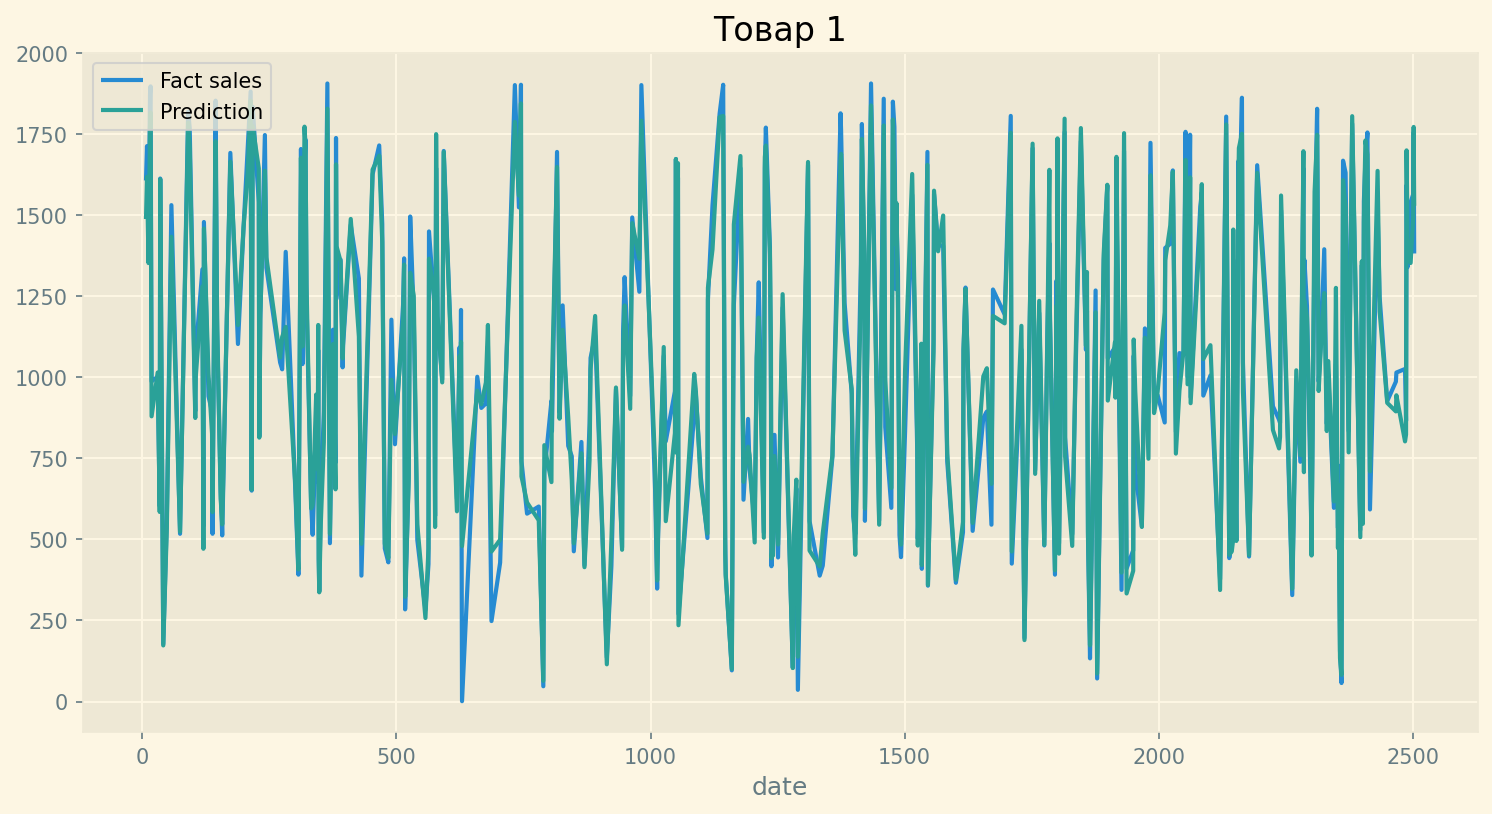

In [107]:
plt.figure(figsize=(12, 6), dpi=150)

preds_test.query('key==1')['fact'].plot(label = 'Fact sales')
preds_test.query('key==1')['pred'].plot(label = 'Prediction')

plt.title('Товар 1')
plt.xlabel('date')
plt.legend(loc='upper left')

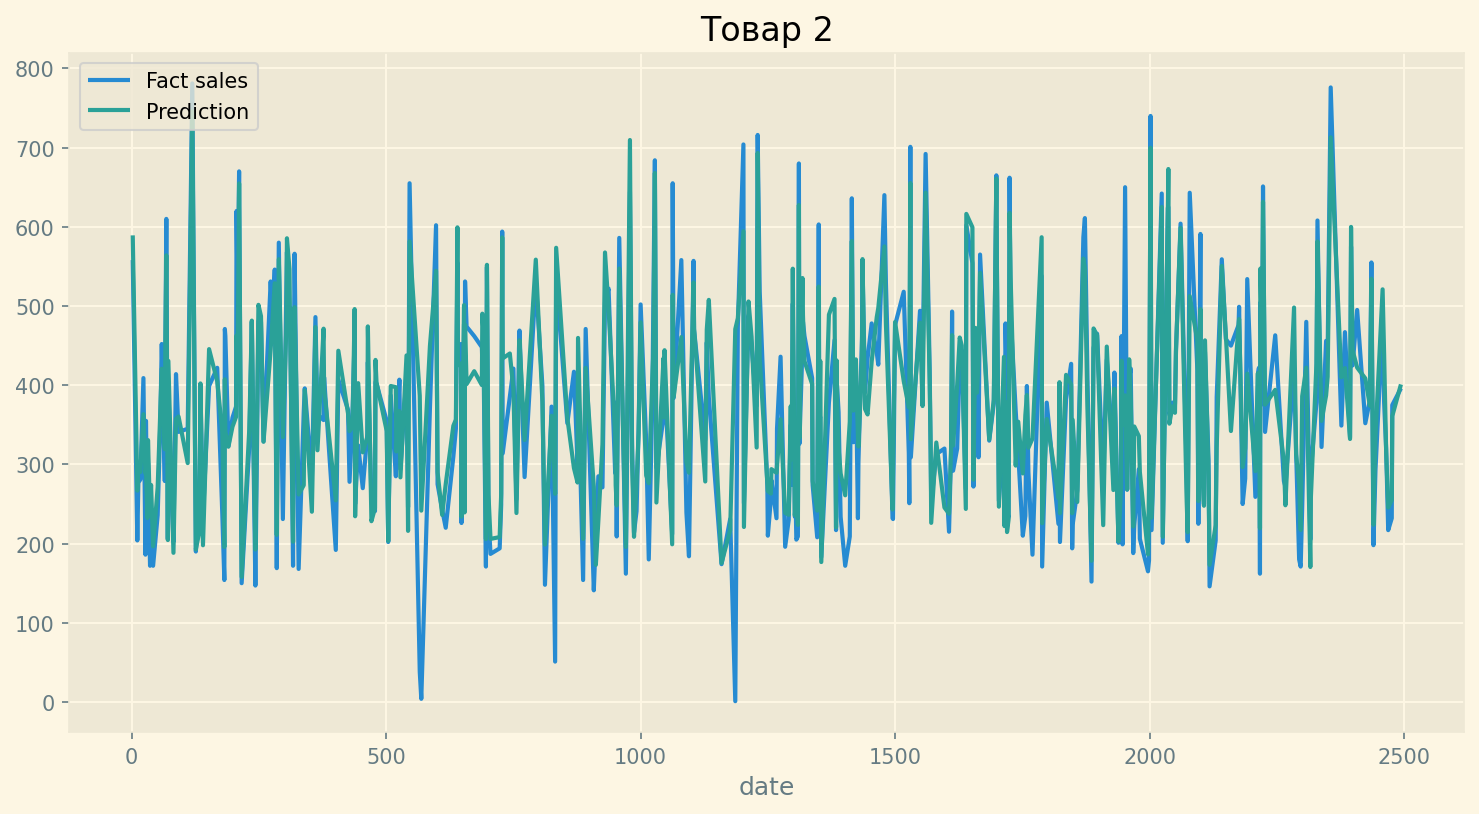

In [108]:
plt.figure(figsize=(12, 6), dpi=150)

preds_test.query('key==2')['fact'].plot(label = 'Fact sales')
preds_test.query('key==2')['pred'].plot(label = 'Prediction')

plt.title('Товар 2')
plt.xlabel('date')
plt.legend(loc='upper left')

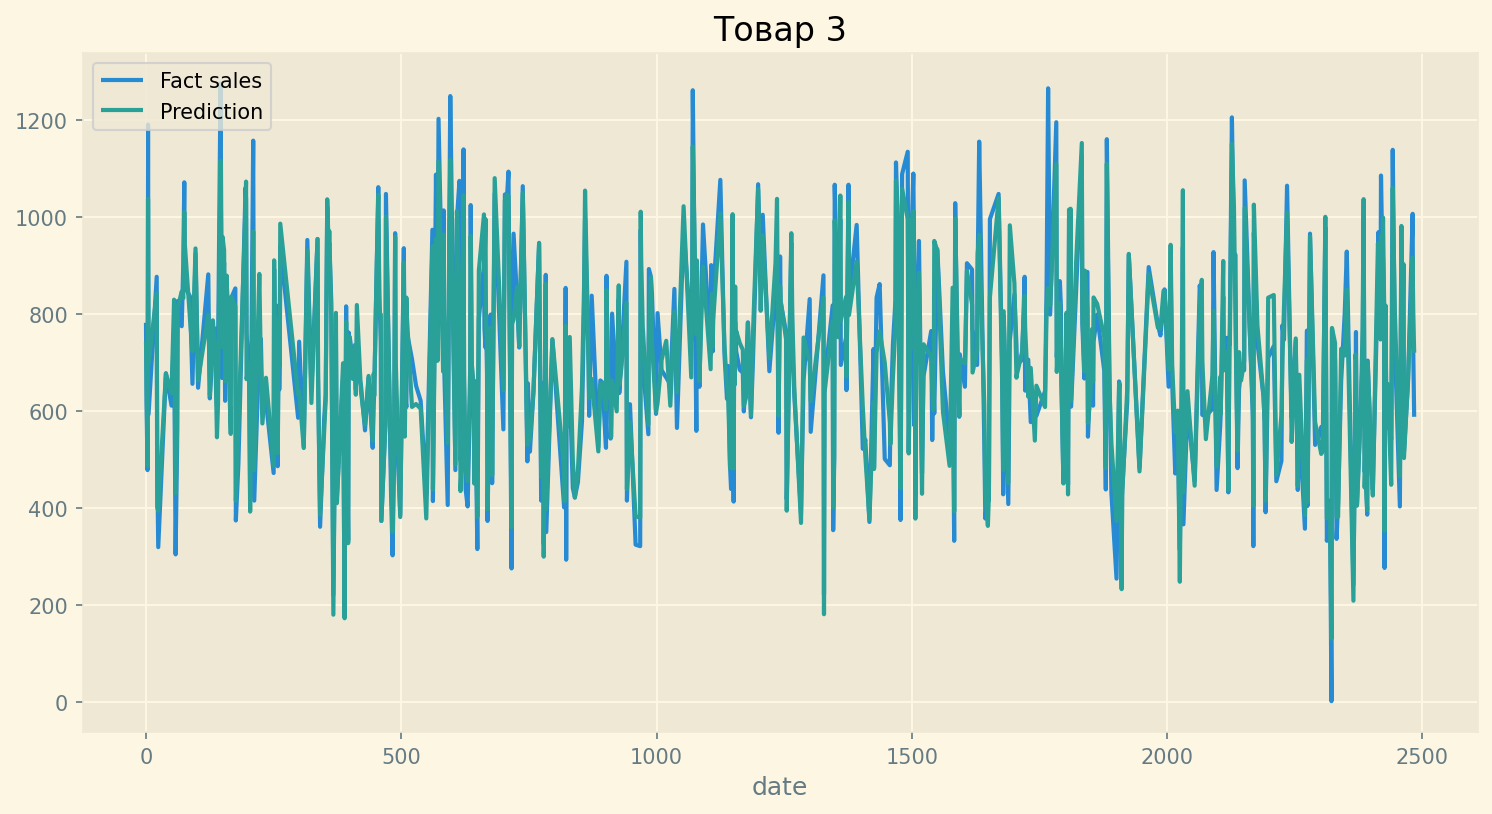

In [109]:
plt.figure(figsize=(12, 6), dpi=150)

preds_test.query('key==3')['fact'].plot(label = 'Fact sales')
preds_test.query('key==3')['pred'].plot(label = 'Prediction')

plt.title('Товар 3')
plt.xlabel('date')
plt.legend(loc='upper left')

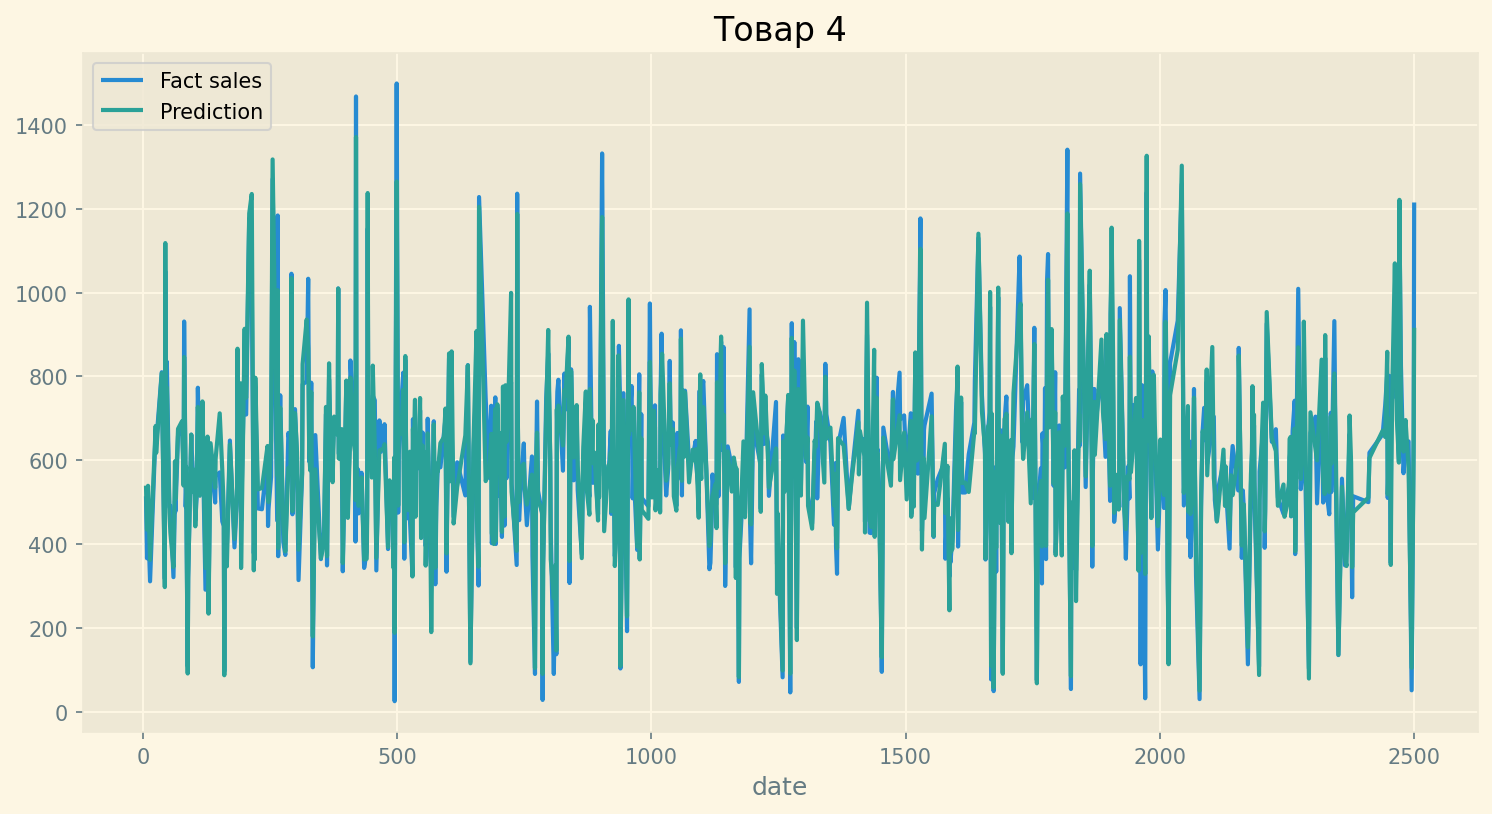

In [110]:
plt.figure(figsize=(12, 6), dpi=150)

preds_test.query('key==4')['fact'].plot(label = 'Fact sales')
preds_test.query('key==4')['pred'].plot(label = 'Prediction')

plt.title('Товар 4')
plt.xlabel('date')
plt.legend(loc='upper left')

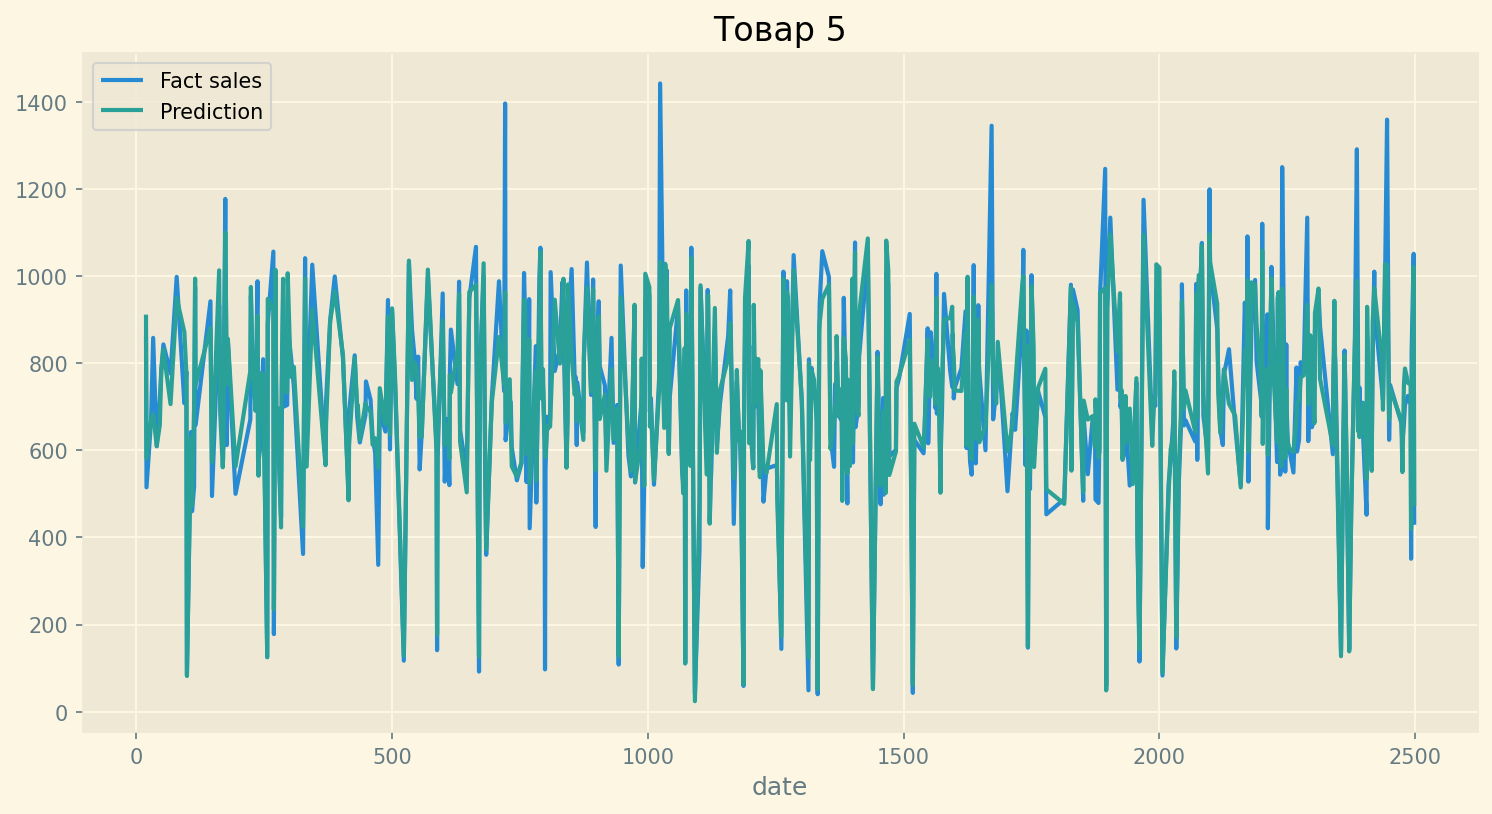

In [111]:
plt.figure(figsize=(12, 6), dpi=150)

preds_test.query('key==5')['fact'].plot(label = 'Fact sales')
preds_test.query('key==5')['pred'].plot(label = 'Prediction')

plt.title('Товар 5')
plt.xlabel('date')
plt.legend(loc='upper left')

In [112]:
# Создание тестового df для построения прогноза с 31.07.2023.

df_submission.drop(columns=['y_no_outl'],inplace=True)

In [113]:
preds_sub = model.predict(df_submission)
preds_sub

array([ 2.74303221,  2.04335232,  1.5026655 , ..., -0.33506628,
       -0.63002675, -0.79868816])

In [114]:
preds_sub = pd.DataFrame(preds_sub)
preds_sub.columns = ['pred']
preds_sub_inverse = scaler.inverse_transform(preds_sub['pred'])
preds_sub_inverse = pd.DataFrame(preds_sub_inverse, columns = ['pred'])

submission = pd.concat([df_submission[['day_id','key']].reset_index(drop=True), preds_sub_inverse], axis = 1)
submission['key'] = pd.Series(submission['key']).str.replace('.0', '').astype(int)
submission.head()

,day_id,key,pred
0,2023-08-01,1,1563.279603
1,2023-08-02,1,1336.493107
2,2023-08-03,1,1161.240868
3,2023-08-04,1,1074.527941
4,2023-08-05,1,1051.145891


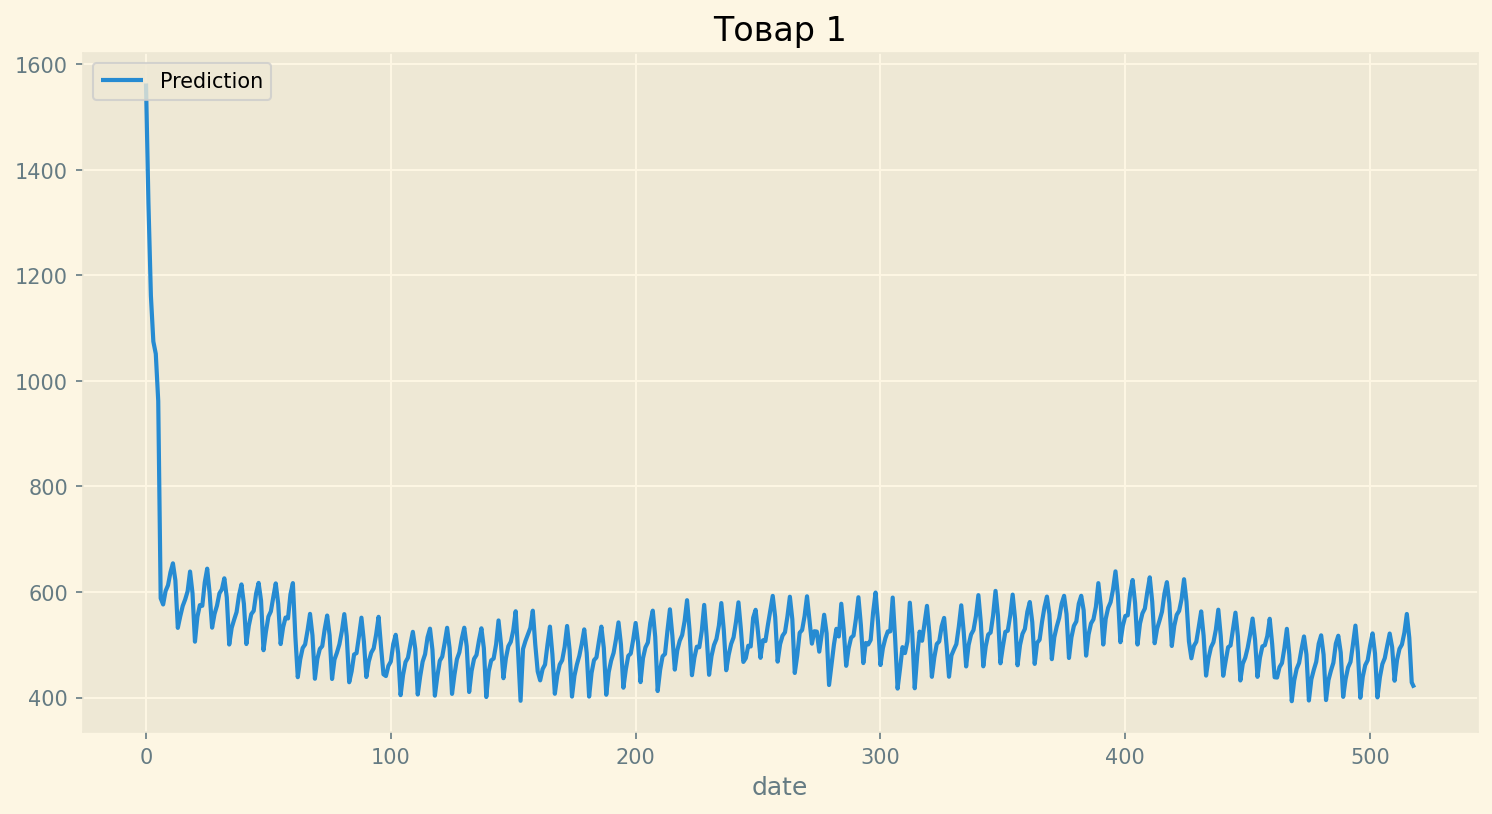

In [115]:
plt.figure(figsize=(12, 6), dpi=150)

submission.query('key==1')['pred'].plot(label = 'Prediction')

plt.title('Товар 1')
plt.xlabel('date')
plt.legend(loc='upper left')

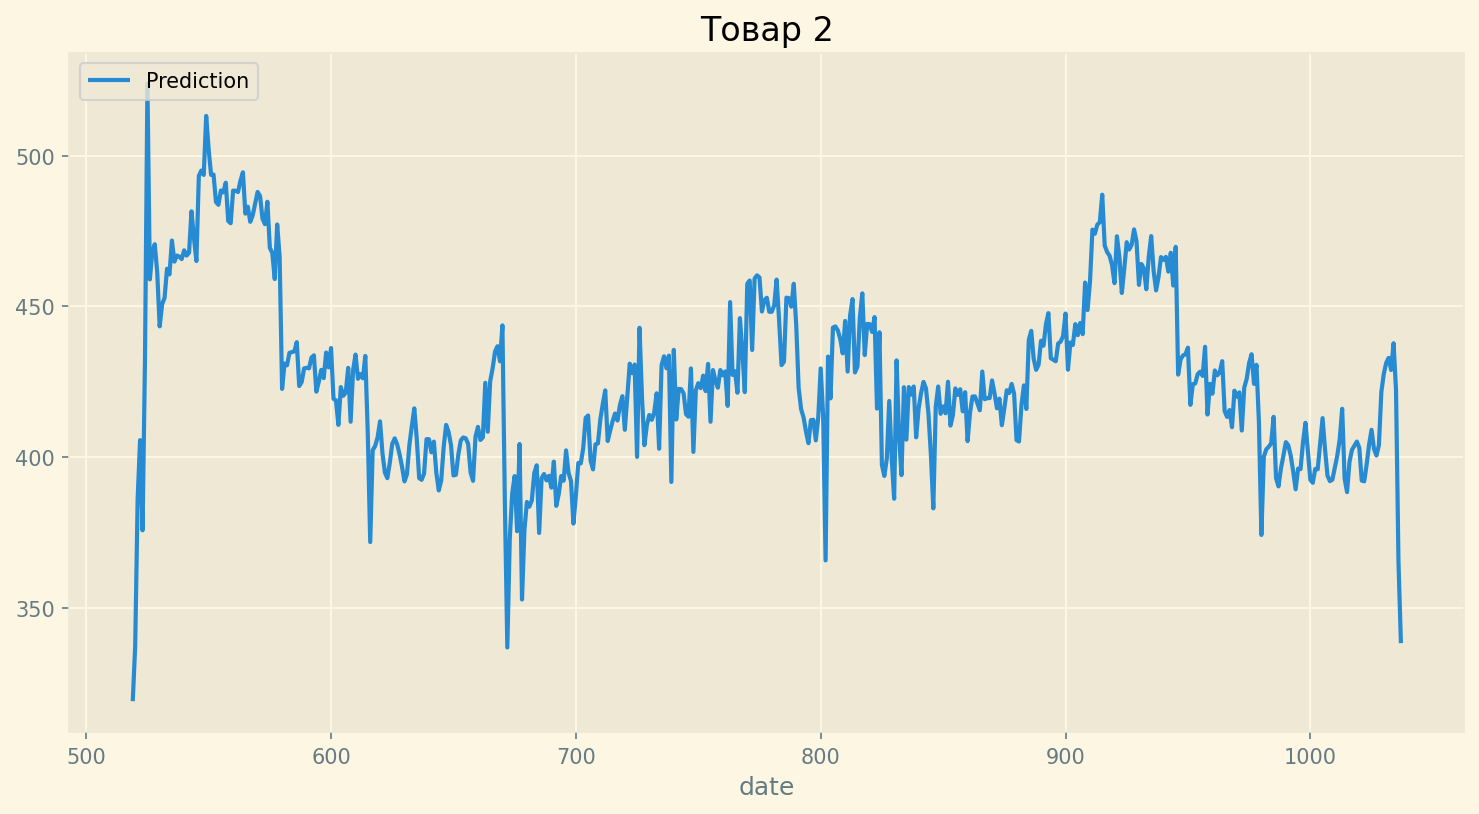

In [116]:
plt.figure(figsize=(12, 6), dpi=150)

submission.query('key==2')['pred'].plot(label = 'Prediction')

plt.title('Товар 2')
plt.xlabel('date')
plt.legend(loc='upper left')

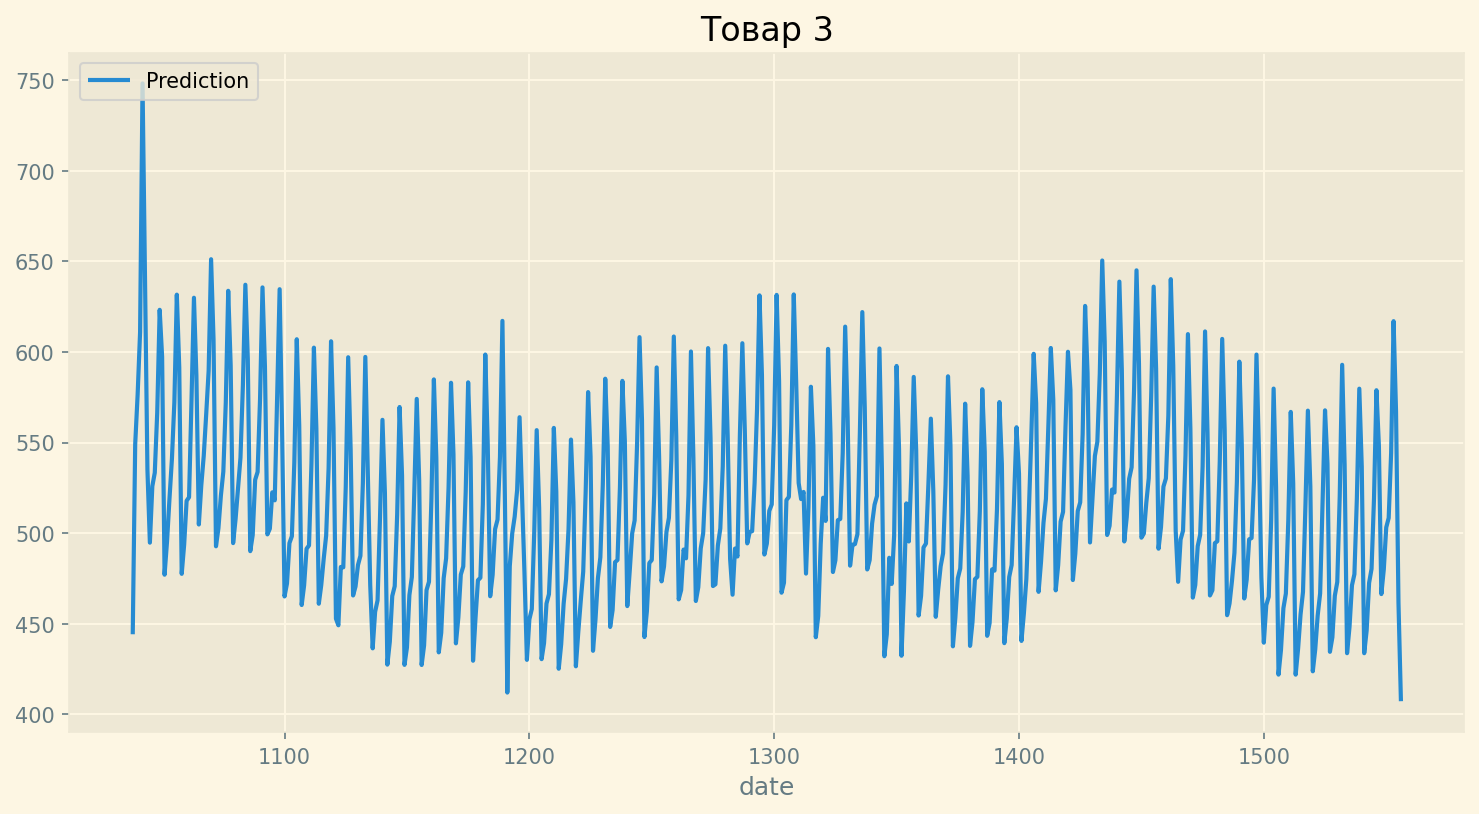

In [117]:
plt.figure(figsize=(12, 6), dpi=150)

submission.query('key==3')['pred'].plot(label = 'Prediction')

plt.title('Товар 3')
plt.xlabel('date')
plt.legend(loc='upper left')

In [127]:
submission.query('key==4')['pred']

1557    320.981510
1558    410.582080
1559    438.411754
1560    525.182234
1561    545.799228
           ...    
2071    530.857918
2072    582.203595
2073    512.673668
2074    450.700680
2075    405.432693
Name: pred, Length: 519, dtype: float64

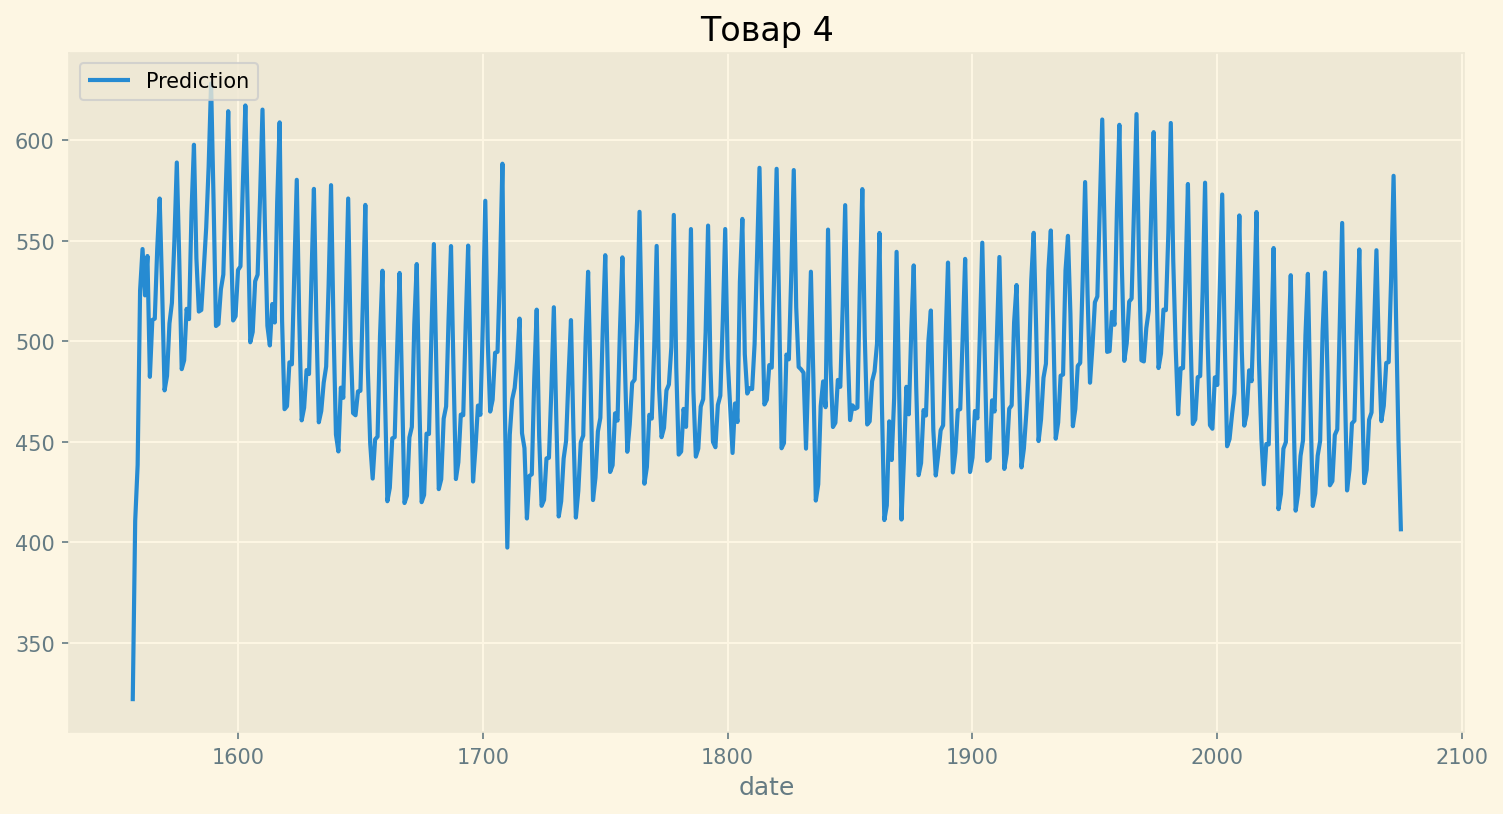

In [118]:
plt.figure(figsize=(12, 6), dpi=150)

submission.query('key==4')['pred'].plot(label = 'Prediction')

plt.title('Товар 4')
plt.xlabel('date')
plt.legend(loc='upper left')

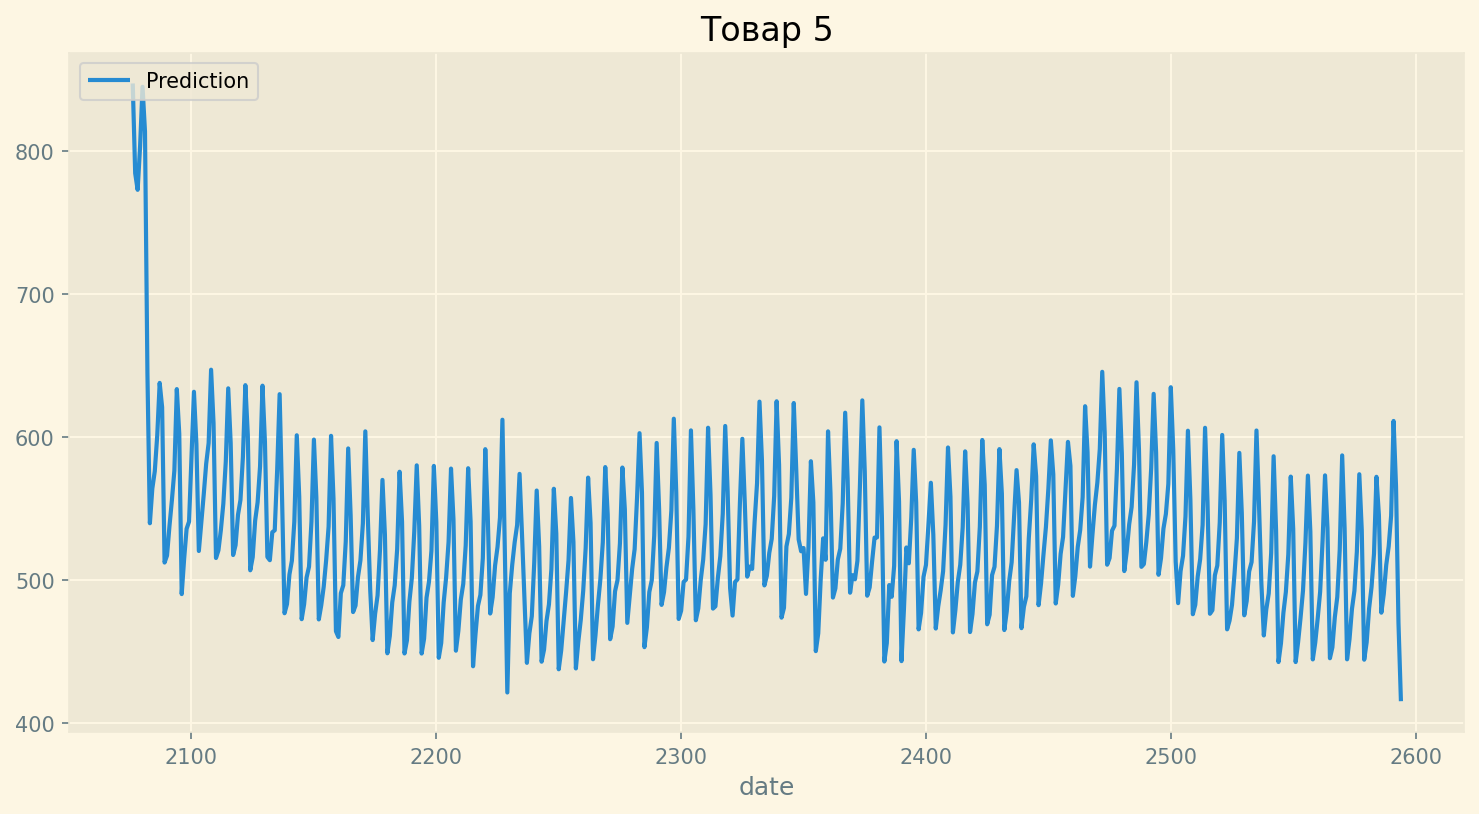

In [119]:
plt.figure(figsize=(12, 6), dpi=150)

submission.query('key==5')['pred'].plot(label = 'Prediction')

plt.title('Товар 5')
plt.xlabel('date')
plt.legend(loc='upper left')

Text(0.5, 0, 'Importance')

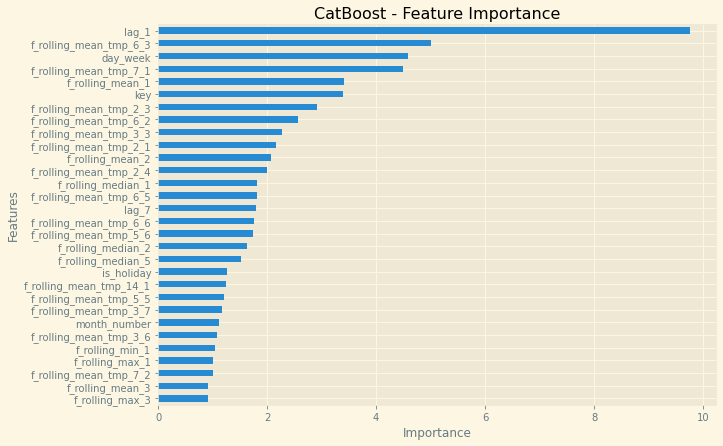

In [120]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')